In [1]:
import sys
import logging
import pickle
import yaml
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from joblib import hash, dump, load
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
from wmaze import MyEnv as Env
import deer.experiment.base_controllers as bc

from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
nn_yaml = 'network_simplest.yaml'
internal_dim = 10
fname = 'wmaze_visualization'
set_network = None #['foraging_mb', 30, True]

In [3]:
parameters = {
    'nn_yaml': nn_yaml,
    'higher_dim_obs': True,
    'internal_dim': internal_dim,
    'fname': fname,
    'steps_per_epoch': 1000,
    'epochs': 40,
    'steps_per_test': 1000,
    'period_btw_summary_perfs': 1,
    'encoder_type': 'regular',
    'frame_skip': 2,
    'learning_rate': 1*1E-4,
    'learning_rate_decay': 1.0,
    'discount': 0.9,
    'epsilon_start': 1.0,
    'epsilon_min': 1.0,
    'epsilon_decay': 1000,
    'update_frequency': 1,
    'replay_memory_size': 100000, #50000
    'batch_size': 64,
    'freeze_interval': 1000,
    'deterministic': False,
    'loss_weights': [0, 0, 0, 1, 0],
    'nstep': 15,
    'expand_tcm': True,
    'encoder_type': 'regular'
    }

In [4]:
rng = np.random.RandomState()
env = Env(rng, contingency=[2, 3])

# Algorithm
learning_algo = CRAR(
    env, parameters['freeze_interval'], parameters['batch_size'], rng,
    high_int_dim=False, internal_dim=parameters['internal_dim'],
    lr=parameters['learning_rate'], nn_yaml=parameters['nn_yaml'],
    double_Q=True, loss_weights=parameters['loss_weights'],
    encoder_type=parameters['encoder_type'],
    nstep=parameters['nstep'],
    expand_tcm=parameters['expand_tcm']
    )

# Policies
train_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.3)
test_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 0.)

# Initialize Agent
agent = NeuralAgent(
    env, learning_algo, parameters['replay_memory_size'], 1,
    parameters['batch_size'], rng,
    train_policy=train_policy, test_policy=test_policy)
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(10, 500)

# Attach controllers
agent.attach(bc.VerboseController( evaluate_on='epoch', periodicity=1))
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters['learning_rate'],
    learning_rate_decay=parameters['learning_rate_decay'],
    periodicity=1))
agent.attach(bc.TrainerController(
    evaluate_on='action', periodicity=parameters['update_frequency'],
    show_episode_avg_V_value=True, show_avg_Bellman_residual=True))
best_controller = bc.FindBestController(
    validationID=Env.VALIDATION_MODE,
    testID=None, unique_fname=fname, savefrequency=5)
agent.attach(best_controller)
agent.attach(bc.InterleavedTestEpochController(
    id=Env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],
    periodicity=5, show_score=True, summarize_every=1, unique_fname=fname))

======= EPOCH 1: 0.6324746608734131 sec ======
======= EPOCH 2: 0.38486433029174805 sec ======
======= EPOCH 3: 0.37318944931030273 sec ======
======= EPOCH 4: 0.3790109157562256 sec ======
======= EPOCH 5: 0.3718423843383789 sec ======
======= EPOCH 6: 0.38016843795776367 sec ======
======= EPOCH 7: 0.3662257194519043 sec ======
======= EPOCH 8: 0.3681504726409912 sec ======
======= EPOCH 9: 0.3861255645751953 sec ======
======= EPOCH 10: 0.35260510444641113 sec ======


In [5]:
agent._learning_algo.device

device(type='cuda', index=0)

In [6]:
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(parameters['epochs'], parameters['steps_per_epoch'])

Average (on the epoch) training loss: 0.002644826797434007
Episode average V value: 0.1236040171161294
epoch 1:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3


/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


SUMMARIZING TEST PERF
== Mean score per episode is 0.9999000099990001 over 1 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/wmaze.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(all_possib_inp).float().to(device)
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/wmaze.py:255: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 1: 32.089258909225464 sec ======
Average (on the epoch) training loss: 0.000815697420246579
Episode average V value: 0.09504896385967732
epoch 2:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 2: 28.299707889556885 sec ======
Average (on the epoch) training loss: 0.00045809867435082197
Episode average V value: 0.08550511209484571
epoch 3:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 3: 29.911418676376343 sec ======
Average (on the epoch) training loss: 0.0004678494708493872
Episode average V value: 0.07438689970225096
epoch 4:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 4: 27.847916841506958 sec ======
Average (on the epoch) training loss: 0.0005902689656371081
Episode average V value: 0.06860270415246486
epoch 5:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 5: 27.47505283355713 sec ======
Average (on the epoch) training loss: 0.0004027775291387457
Episode average V value: 0

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/wmaze.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(all_possib_inp).float().to(device)
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/wmaze.py:255: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 6: 31.590603351593018 sec ======
Average (on the epoch) training loss: 0.00043179001084618564
Episode average V value: 0.05534034628081728
epoch 7:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 7: 28.05810809135437 sec ======
Average (on the epoch) training loss: 0.00044595809948074817
Episode average V value: 0.04883628070563496
epoch 8:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 8: 27.201035737991333 sec ======
Average (on the epoch) training loss: 0.0007317733500427437
Episode average V value: 0.037447160014787595
epoch 9:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 9: 28.198807954788208 sec ======
Average (on the epoch) training loss: 0.000472934439689908
Episode average V value: 0.04069368019028154
epoch 10:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 10: 27.688201904296875 sec ======
Average (on the epoch) training loss: 0.0005726327724330815
Episode average V valu

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/wmaze.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(all_possib_inp).float().to(device)
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/wmaze.py:255: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 11: 31.346251726150513 sec ======
Average (on the epoch) training loss: 0.0007071705640286154
Episode average V value: 0.037088038136919695
epoch 12:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 12: 28.23036479949951 sec ======
Average (on the epoch) training loss: 0.0005447539628153209
Episode average V value: 0.03226159416511655
epoch 13:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 13: 27.169228076934814 sec ======
Average (on the epoch) training loss: 0.0005559776190283401
Episode average V value: 0.03382832648605108
epoch 14:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 14: 27.73644256591797 sec ======
Average (on the epoch) training loss: 0.00028708649648177695
Episode average V value: 0.02809134352952242
epoch 15:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 0.3
======= EPOCH 15: 27.299338817596436 sec ======
Average (on the epoch) training loss: 0.0004893341392726711
Episode average 

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/wmaze.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(all_possib_inp).float().to(device)
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/wmaze.py:255: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 16: 31.26685929298401 sec ======



KeyboardInterrupt



## Visualize performance

In [12]:
env._arm_visits

[3, 2]

In [13]:
env._contingency

[2, 3]

In [7]:
agent.setNetwork(f'{fname}/fname', nEpoch=5)

FileNotFoundError: [Errno 2] No such file or directory: './nnets/wmaze_visualization/fname.epoch=5'

In [80]:
agent.setNetwork(f'foraging_simpler_dim10/foraging_entro_5/fname', nEpoch=40)

In [7]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()

for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

### Frame by frame

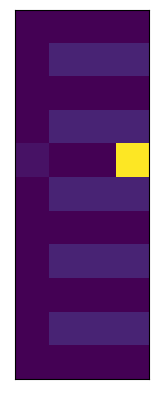

tensor(3, device='cuda:0')


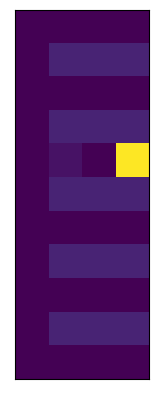

tensor(3, device='cuda:0')


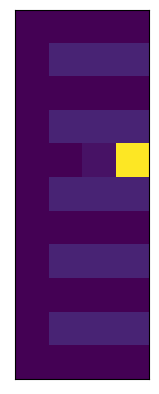

tensor(3, device='cuda:0')


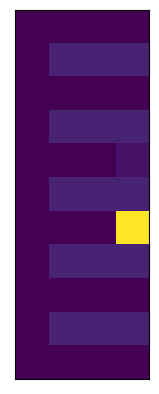

tensor(3, device='cuda:0')


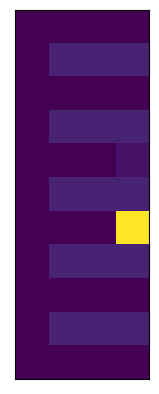

tensor(3, device='cuda:0')


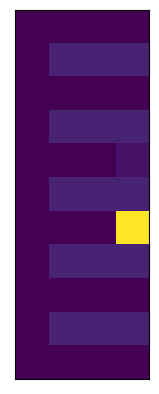

tensor(3, device='cuda:0')


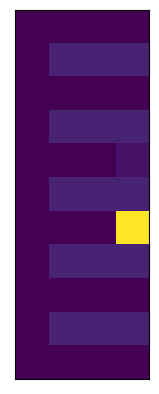

tensor(3, device='cuda:0')


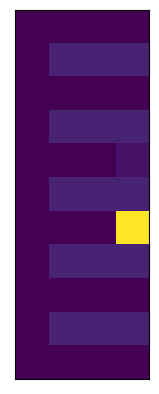

tensor(0, device='cuda:0')


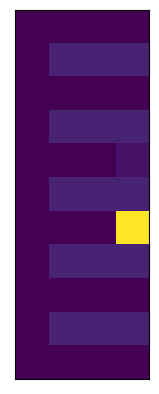

In [8]:
%matplotlib inline

frames = []

for i in range(100):
    obs = env.observe()
    _obs = obs[0].reshape((env._maze_width, env._maze_length))
    #_obs = obs[0].reshape((env._maze_length, env._maze_width))
    plt.figure()
    frame = _obs.squeeze()
    plt.imshow(frame)
    frames.append(frame)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    if is_terminal: break
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward, _ = agent._step()
    print(action)
    agent._Vs_on_last_episode.append(V)
    is_terminal = (env.inTerminalState() or action ==0)

### As animation

<IPython.core.display.Javascript object>


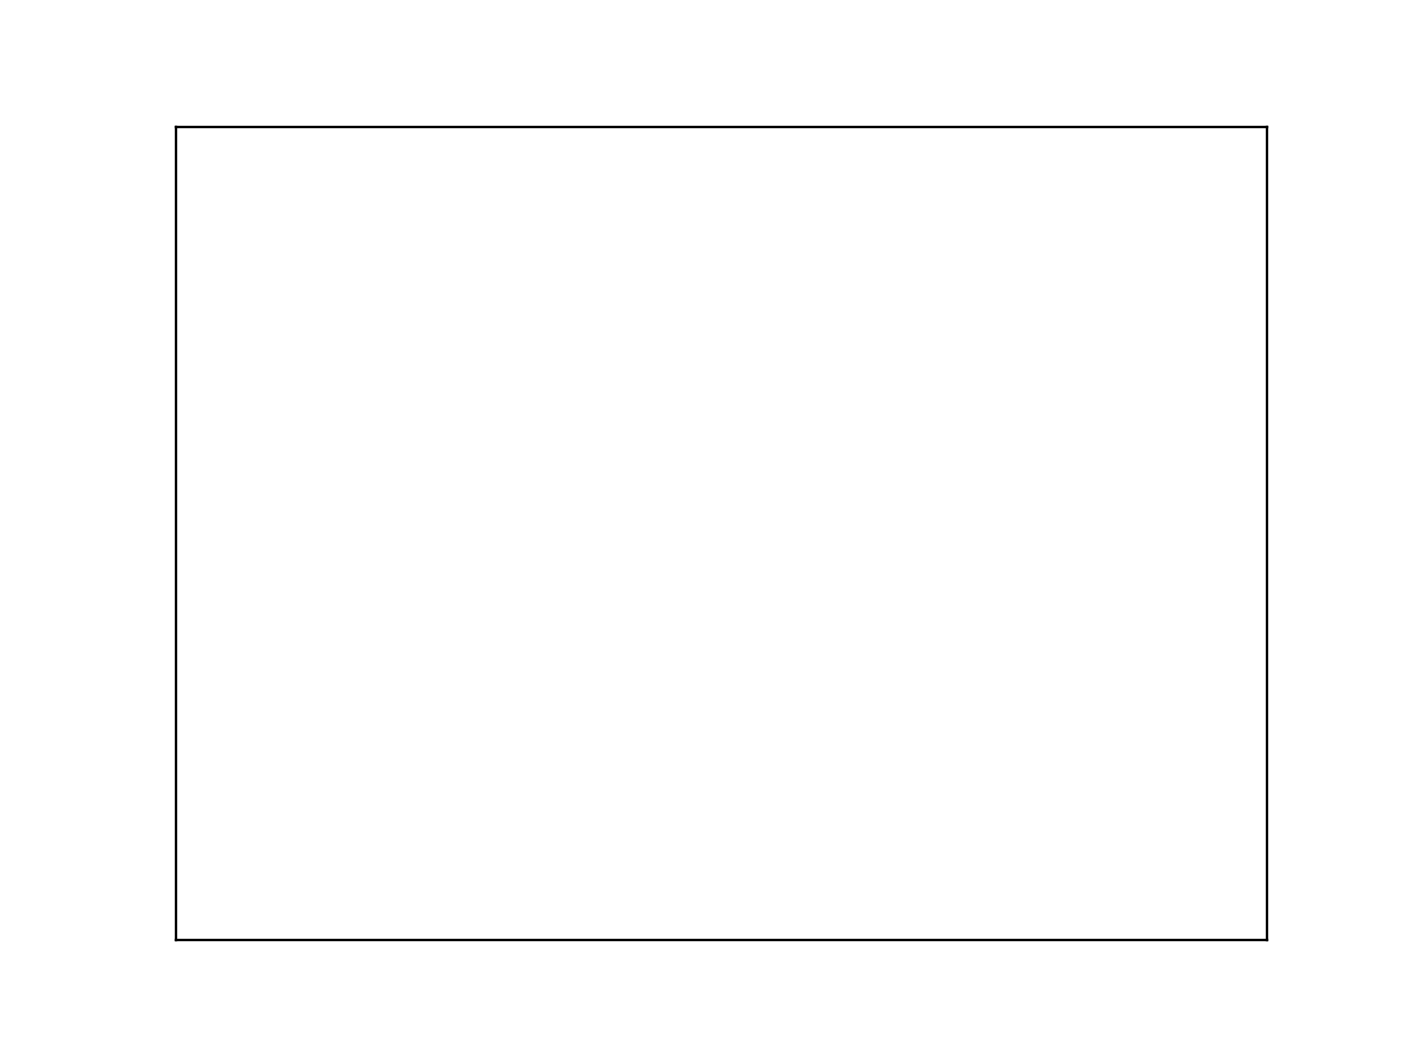

NameError: name 'height' is not defined

In [9]:
%matplotlib notebook

import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(np.zeros((height, width)))

def init():
    plt.cla()
    im = ax.imshow(_obs)
    return [im]

def animate(i, *args, **kwargs):
    plt.cla()
    im = ax.imshow(frames[i])
#     obs = env.observe()
#     _obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
#     _obs = np.flip(_obs.squeeze())
#     im = ax.imshow(_obs)
#     for i in range(len(obs)):
#         agent._state[i][0:-1] = agent._state[i][1:]
#         agent._state[i][-1] = obs[i]
#         V, action, reward, _ = agent._step()
#         agent._Vs_on_last_episode.append(V)
    return [im]

ani = animation.FuncAnimation(fig, animate, init_func=init, 
     frames=len(frames), blit=False, repeat=True)
ani.save(f'figs/{fname}/behavior_r2_3.gif', writer="ffmpeg", fps = 4)
fig.show()